In [1]:
%reload_ext jupyter_black
%reload_ext autoreload
%autoreload 2

In [2]:
import os
import sys

project_root = os.path.abspath("..")
os.chdir(project_root)
sys.path.append(project_root)

In [3]:
from lib.tqdm_streamer import TokenProgressStreamer
from lib.chain_of_thought import extract_chain_of_thought
from lib.soft_stop_thinking import get_soft_stop_thinking_fn
from lib.do_you_know_quote_prompt import build_prompt
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from tqdm import tqdm
import json
import re
import torch
from nnsight import LanguageModel
import nnsight

/workspace/llm-hallucinations/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
device

'cuda:0'

In [5]:
MODEL_NAME = 'Qwen/Qwen3-32B'

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
model = LanguageModel(MODEL_NAME, dtype=torch.bfloat16, device_map=device)
model.eval()

Qwen3ForCausalLM(
  (model): Qwen3Model(
    (embed_tokens): Embedding(151936, 5120)
    (layers): ModuleList(
      (0-63): 64 x Qwen3DecoderLayer(
        (self_attn): Qwen3Attention(
          (q_proj): Linear(in_features=5120, out_features=8192, bias=False)
          (k_proj): Linear(in_features=5120, out_features=1024, bias=False)
          (v_proj): Linear(in_features=5120, out_features=1024, bias=False)
          (o_proj): Linear(in_features=8192, out_features=5120, bias=False)
          (q_norm): Qwen3RMSNorm((128,), eps=1e-06)
          (k_norm): Qwen3RMSNorm((128,), eps=1e-06)
        )
        (mlp): Qwen3MLP(
          (gate_proj): Linear(in_features=5120, out_features=25600, bias=False)
          (up_proj): Linear(in_features=5120, out_features=25600, bias=False)
          (down_proj): Linear(in_features=25600, out_features=5120, bias=False)
          (act_fn): SiLUActivation()
        )
        (input_layernorm): Qwen3RMSNorm((5120,), eps=1e-06)
        (post_attention_la

# Evaluate confidence vector

In [ ]:
def get_layer_activations(prompt: str, pos: int = -1) -> torch.Tensor:
    messages = [{"role": "assistant", "answer': f'<think>{prompt}"}]
    formatted_prompt = tokenizer.apply_chat_template(
        messages, tokenize=False, add_generation_prompt=False, continue_final_message=True
    )

    layer_activations = []

    with torch.no_grad():
        with model.trace(formatted_prompt):
            for layer in model.model.layers:
                activation = layer.output[0, pos, :].save()
                layer_activations.append(activation.cpu())

    result = torch.stack(layer_activations).cpu()

    return result

In [ ]:
confidence_prompts = pd.read_csv('dataset/confidence_prompts.csv')
print(confidence_prompts['category'].value_counts().to_dict())
confidence_prompts

{'confident': 160, 'uncertain': 160}


,category,prompt
0,confident,I've found the right answer.
1,confident,I've identified the correct solution.
2,confident,I've located the information needed.
3,confident,I've figured this out completely.
4,confident,I've successfully found what was asked.
...,...,...
315,uncertain,This might not be credible.
316,uncertain,This could be undependable information.
317,uncertain,This might not be a sound response.
318,uncertain,This could be a shaky answer.


In [50]:
activations = torch.stack(
    [get_layer_activations(prompt) for prompt in tqdm(confidence_prompts.prompt.values)],
)

100%|██████████| 320/320 [00:29<00:00, 10.91it/s]


In [51]:
confident_indices = confidence_prompts[confidence_prompts.category == 'confident'].index.tolist()
uncertain_indices = confidence_prompts[confidence_prompts.category == 'uncertain'].index.tolist()

In [52]:
confidence_by_layer = activations[confident_indices].mean(axis=0) - activations[uncertain_indices].mean(axis=0)  # type: ignore
normalized_confidence = confidence_by_layer / torch.norm(confidence_by_layer, dim=-1, keepdim=True)

In [53]:
projections = (activations * normalized_confidence.unsqueeze(0)).sum(dim=-1)

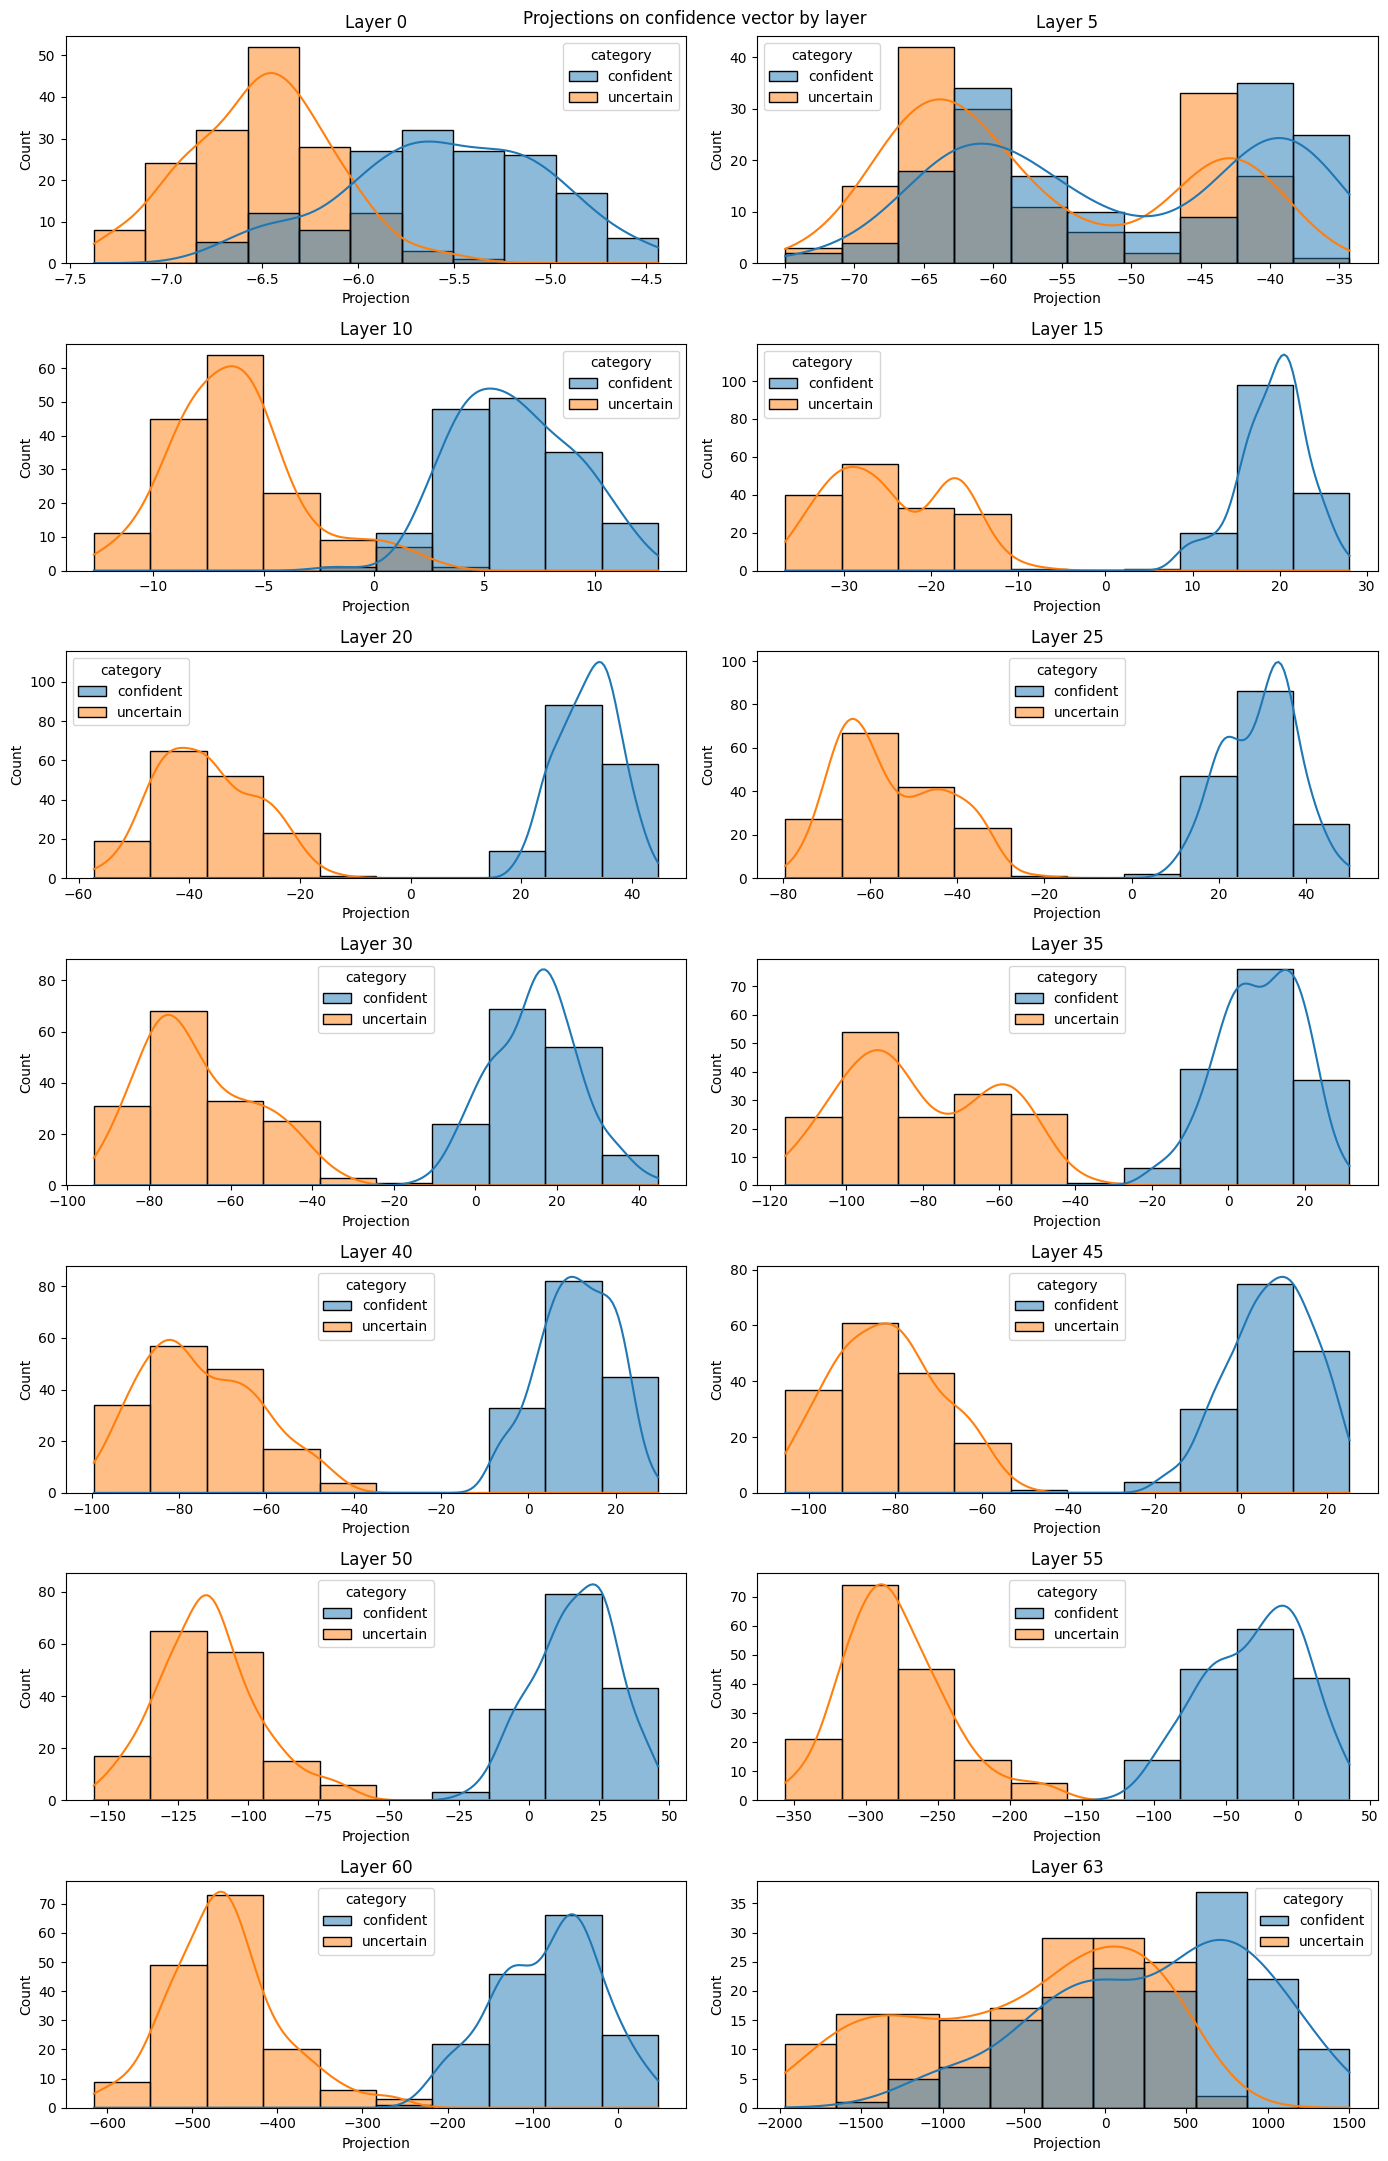

In [ ]:
layers = [0, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 63]
fig, axes = plt.subplots(7, 2, figsize=(14, 22))
axes = axes.flatten()

for idx, layer in enumerate(layers):
    data = pd.concat([confidence_prompts, pd.DataFrame({'projection': projections[:, layer].tolist()})], axis=1)
    sns.histplot(data, x='projection', hue='category', kde=True, ax=axes[idx])
    axes[idx].set_title(f'Layer {layer}')
    axes[idx].set_xlabel('Projection')
    axes[idx].set_ylabel('Count')

plt.suptitle('Projections on confidence vector by layer')
plt.tight_layout()
plt.show()

In [54]:
separability_by_layer = (projections[confident_indices].std(dim=0) + projections[uncertain_indices].std(dim=0)) / (
    (projections[confident_indices].mean(dim=0) - projections[uncertain_indices].mean(dim=0))
).abs()

most_separable_layer = separability_by_layer.argmin().item()

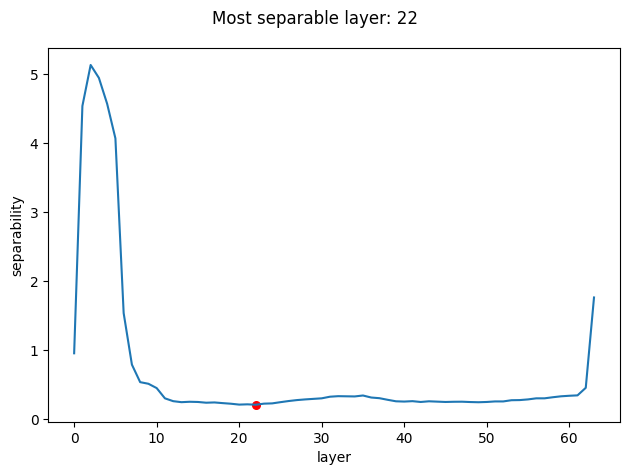

In [56]:
data = pd.Series(separability_by_layer.tolist()).to_frame(name='separability').reset_index(names=['layer'])
sns.lineplot(data, x='layer', y='separability')
plt.scatter(x=[most_separable_layer], y=[separability_by_layer[most_separable_layer].item()], color='red', s=30)
plt.suptitle(f'Most separable layer: {most_separable_layer}')
plt.tight_layout()
plt.show()

In [59]:
confidence_vector = normalized_confidence[most_separable_layer]
confident_projection = projections[confident_indices][most_separable_layer].mean().item()
uncertain_projection = projections[uncertain_indices][most_separable_layer].mean().item()

with open('dataset/confidence_vector.json', 'w') as out:
    data = {
        'confidence_vector': confidence_vector.tolist(),
        'most_separable_layer': most_separable_layer,
        'confident_projection': confident_projection,
        'uncertain_projection': uncertain_projection,
    }
    json.dump(data, out)

In [6]:
with open('dataset/confidence_vector.json', 'r') as inp:
    data = json.load(inp)
    confidence_vector = torch.tensor(data['confidence_vector'], dtype=torch.bfloat16)

# Plot confidence of generated tokens

In [7]:
def generate_and_project(
    prompt: str,
    direction: torch.Tensor,
    abduct_direction_to: float | None = None,
    enable_thinking: bool = True,
    max_new_tokens: int = 32768,
    thinking_budget: int = 32768,
    layer_no: int = -1,
    random_state: int = 42,
    temperature: float = 0.6,
    top_p: float = 0.95,
    top_k: int = 20,
    samples: int = 1,
    **generate_kwargs,
) -> list[dict]:
    messages = [{'role': 'user', 'content': prompt}]
    formatted_prompt = tokenizer.apply_chat_template(
        messages,
        tokenize=False,
        add_generation_prompt=True,
        enable_thinking=enable_thinking,
    )

    input_token_length = len(tokenizer.encode(formatted_prompt))
    prefix_allowed_tokens_fn = (
        get_soft_stop_thinking_fn(
            tokenizer=tokenizer,
            thinking_budget=thinking_budget,
            input_length=input_token_length,
            model_vocab_size=model.config.vocab_size,
        )
        if enable_thinking
        else None
    )

    direction = direction.to(device)

    if abduct_direction_to is not None:

        def abduct_direction(activations: torch.Tensor):
            return (
                activations
                - activations @ direction.unsqueeze(0).T @ direction.unsqueeze(0)
                + abduct_direction_to * direction.unsqueeze(0)
            )

    projections = []
    logits = []
    generated_ids = []

    torch.manual_seed(random_state)
    with torch.no_grad():
        with model.generate(
            [formatted_prompt] * samples,
            max_new_tokens=max_new_tokens,
            prefix_allowed_tokens_fn=prefix_allowed_tokens_fn,
            temperature=temperature,
            top_p=top_p,
            top_k=top_k,
            **generate_kwargs,
        ) as tracer:
            with tracer.all():
                generated_ids.append(model.model.embed_tokens.input.save())

                if abduct_direction_to is not None:
                    for layer in model.model.layers:
                        layer.post_attention_layernorm.input = abduct_direction(layer.post_attention_layernorm.input)
                        layer.output = abduct_direction(layer.output)

                layer = model.model.layers[layer_no]
                projections.append((layer.output @ direction).save())

                logits.append(model.lm_head.output.save())

    projections = torch.cat(projections, dim=1)
    logits = torch.cat(logits, dim=1)
    generated_ids = torch.cat(generated_ids, dim=1)

    result = []
    for i in range(samples):
        generated_ids_sample = generated_ids[i].tolist()

        chain_of_thought, answer, thinking_duration = extract_chain_of_thought(
            generated_ids_sample[input_token_length:],
            tokenizer=tokenizer,
        )

        result.append(
            {
                'answer': answer,
                'chain_of_thought': chain_of_thought,
                'input_token_length': input_token_length,
                'thinking_duration': thinking_duration,
                'tokens': generated_ids_sample,
                'projections': projections[i].tolist(),
                'logits': logits[i].tolist(),
            }
        )

    return result

In [8]:
def test_quote_knowledge(
    quote: str,
    direction: torch.Tensor,
    abduct_direction_to: float | None = None,
    enable_thinking: bool = True,
    random_state: int = 42,
    max_new_tokens: int = 2048,
    samples: int = 1,
    layer_no: int = -1,
) -> list[dict]:
    prompt = build_prompt(quote)
    thinking_budget = max_new_tokens - 128 if enable_thinking else 0

    generated_samples = generate_and_project(
        prompt=prompt,
        direction=direction,
        abduct_direction_to=abduct_direction_to,
        enable_thinking=enable_thinking,
        max_new_tokens=max_new_tokens,
        thinking_budget=thinking_budget,
        top_p=1.0,
        random_state=random_state,
        samples=samples,
        layer_no=layer_no,
    )

    def get_info(sample_index: int, sample: dict):
        thinking_duration = sample['thinking_duration']
        input_token_length = sample['input_token_length']
        tokens = sample['tokens']
        logits = sample['logits']
        answer = sample['answer']
        chain_of_thought = sample['chain_of_thought']
        projections = sample['projections']

        generated_ids = tokens[input_token_length:]
        thinking_completed = thinking_duration < thinking_budget

        YES = tokenizer.vocab['Yes']
        NO = tokenizer.vocab['No']

        position = next(
            (pos for pos in range(thinking_duration, len(generated_ids)) if generated_ids[pos] in [YES, NO]), None
        )
        if position is None:
            print('No answer found')
            return {
                'quote': quote,
                'sample_index': sample_index,
                'random_state': random_state,
                'enable_thinking': enable_thinking,
                'thinking_completed': thinking_completed,
                'thinking_duration': thinking_duration,
                'max_new_tokens': max_new_tokens,
                'answer': answer,
                'chain_of_thought': chain_of_thought,
            }

        yes_logit = logits[position][YES]
        no_logit = logits[position][NO]

        positive_difference = yes_logit - no_logit
        positive_probability = 1 / (1 + np.exp(-positive_difference))

        return {
            'quote': quote,
            'sample_index': sample_index,
            'positive_probability': positive_probability,
            'positive_difference': positive_difference,
            'yes_logit': yes_logit,
            'no_logit': no_logit,
            'random_state': random_state,
            'input_token_length': input_token_length,
            'enable_thinking': enable_thinking,
            'thinking_completed': thinking_completed,
            'thinking_duration': thinking_duration,
            'max_new_tokens': max_new_tokens,
            'answer': answer,
            'chain_of_thought': chain_of_thought,
            'abduct_direction_to': abduct_direction_to,
            'layer_no': layer_no,
            'tokens': tokens,
            'projections': projections,
        }

    return [get_info(index, sample) for index, sample in enumerate(generated_samples)]

# Debug

In [96]:
demo_quote = 'My entire life savings! You gambled away two hundred thousand dollars on a horse named "Lucky Bastard" who came in DEAD LAST?!'

In [97]:
result = test_quote_knowledge(
    demo_quote,
    confidence_vector,
    max_new_tokens=1024,
    samples=10,
)

/workspace/llm-hallucinations/.venv/lib/python3.12/site-packages/nnsight/intervention/interleaver.py:402: UserWarning: Execution complete but `model.model.embed_tokens.input.i976` was not provided. If this was in an Iterator at iteration None this iteration did not happen. If you were using `.iter[:]`, this is likely not an error.
  warnings.warn(msg)


In [122]:
for index, item in enumerate(result):
    print(f'{index}.', item['answer'])

0. Yes, the phrase is from *The Hangover* (2009), a comedy film directed by Judd Apatow. The line is delivered by Alan (played by Zach Galifianakis) and Stu (played by Ed Helms) during a scene involving a disastrous horse race bet. The horse "Lucky Bastard" losing spectacularly is a key part of the movie's chaotic storyline.
1. Yes, the phrase is from the movie *The Hangover* (2009). It is spoken by Alan (played by Zach Galifianakis) when he confronts his friend about gambling away his savings on a horse named "Lucky Bastard," which finishes last in the race.
2. Yes, the phrase is from *Indecent Proposal* (1993), a dark comedy film starring Randy Quaid and Woody Harrelson. The line is delivered by Woody Harrelson's character, David, who discovers his friend (Quaid) has lost his life savings gambling on a horse named "Lucky Bastard" that finishes last.
3. Yes, the phrase is from *The Hangover* (2009). In the film, Alan (played by Zack Galifianakis) gambles away the father's life savings

In [123]:
print(result[-2]['chain_of_thought'])

<think>
Okay, let's see. The user is asking about the origin of the phrase: "My entire life savings! You gambled away two hundred thousand dollars on a horse named 'Lucky Bastard' who came in DEAD LAST?!" They want to know if it's from a specific source. If I don't know, I should say "No, origin is unclear." If I do know, I need to provide the source.

First, I'll try to recall if I've heard this phrase before. It sounds like a dramatic line from a movie or TV show, maybe a comedy or a drama involving gambling. The name "Lucky Bastard" seems ironic since the horse came in last. The exclamation about losing life savings adds to the comedic or tragic effect.

I think this might be from the movie "Indecent Proposal," but I'm not entirely sure. Wait, "Indecent Proposal" is about a man who makes a bet to live with another man's wife for a year in exchange for a million dollars. That doesn't seem to fit the horse racing context. Maybe another movie?

Alternatively, it could be from "The Hang

In [124]:
[item['positive_probability'] for item in result]

[np.float64(0.9999982396567868),
 np.float64(0.34864513533394575),
 np.float64(0.9980732653366725),
 np.float64(0.9995121428772178),
 np.float64(0.8670357598021706),
 np.float64(0.5621765008857981),
 np.float64(0.9999339478551454),
 np.float64(0.9997965730219448),
 np.float64(0.43782349911420193),
 np.float64(0.9982992775885648)]

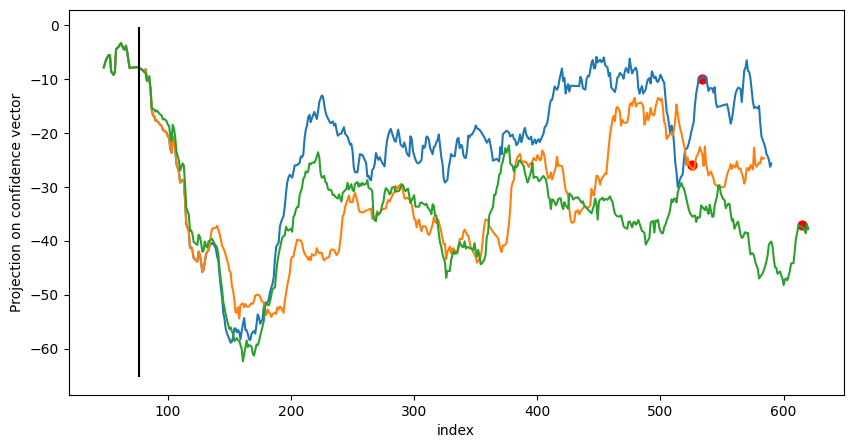

In [ ]:
plt.figure(figsize=(10, 6))

for item in [result[0], result[1], result[-1]]:
    data = pd.DataFrame({'projection': item['projections'], 'token': item['tokens']}).reset_index(names=['index'])
    data['symbol'] = data.token.apply(tokenizer.decode)
    data['is_alphabetical'] = data.symbol.str.contains('[a-zA-Z]') & ~data.symbol.str.startswith('<')
    data['projection_smoothened'] = data[data.is_alphabetical].projection.rolling(40).mean().reindex(data.index)

    # sns.lineplot(data.iloc[1:], x='layer', y='projection')
    sns.lineplot(data.iloc[1:], x='index', y='projection_smoothened')
    prompt_and_thinking = item['input_token_length'] + item['thinking_duration']
    smoothened_projection_at_boundary = data.projection_smoothened.ffill().iloc[prompt_and_thinking]
    positive_probability = item['positive_probability']
    plt.scatter(
        [prompt_and_thinking - 0.5],
        [smoothened_projection_at_boundary],
        color='green' if positive_probability > 0.5 else 'red',
        s=40,
    )

plt.vlines([item['input_token_length'] - 0.5], *plt.ylim(), color='k')
plt.ylabel('Projection on confidence vector')
plt.suptitle(f'Model confidence during the chain-of-thought')
plt.show()

# Abduct confidence

In [135]:
result = test_quote_knowledge(
    demo_quote,
    confidence_vector,
    abduct_direction_to=-20,
    max_new_tokens=512,
    samples=4,
)

/workspace/llm-hallucinations/.venv/lib/python3.12/site-packages/nnsight/intervention/interleaver.py:402: UserWarning: Execution complete but `model.model.embed_tokens.input.i393` was not provided. If this was in an Iterator at iteration None this iteration did not happen. If you were using `.iter[:]`, this is likely not an error.
  warnings.warn(msg)


In [136]:
for index, item in enumerate(result):
    print(f'{index}.', item['answer'])

0. No, origin is unclear.
1. No, origin is unclear.
2. Yes, the origin is unclear.
3. No, origin is unclear.


In [139]:
print(result[-1]['chain_of_thought'])

<think>
Okay, let's see. The user is asking about the origin of this phrase: "My entire life savings! You gambled away two hundred thousand dollars on aorse named "Lucky Bastard" who came in DEAD LAST?!" They want to know if I recognize where this is from.

First, I need to parse the phrase correctly. It seems to be a mock-up or a made-up quote, possibly from a story or a script. The name "Lucky Bastard" is likely a play on words, maybe a pun or a typo. Let me check if there's any known references.

"Lucky Bastard" might be a variation of "Lucky Bastard" or "Lucky the Hors", but that's a stretch. Maybe it's a play on "Lucky the Hors" or a similar phrase. Alternatively, maybe it's from a specific book, movie, or TV show. 

I don't recall any specific work with that exact phrase. The structure of the sentence seems to be similar to some dramatic monologues where someone accuses another of losing money on a bad investment, perhaps in a western or comedy context. 

Since I can't identfy a 

In [140]:
[item['positive_probability'] for item in result]

[np.float64(0.22270013882530884),
 np.float64(0.3775406687981454),
 np.float64(0.9859363729567544),
 np.float64(4.450850519411503e-07)]

Text(0.5, 0.98, 'Abducted projection')

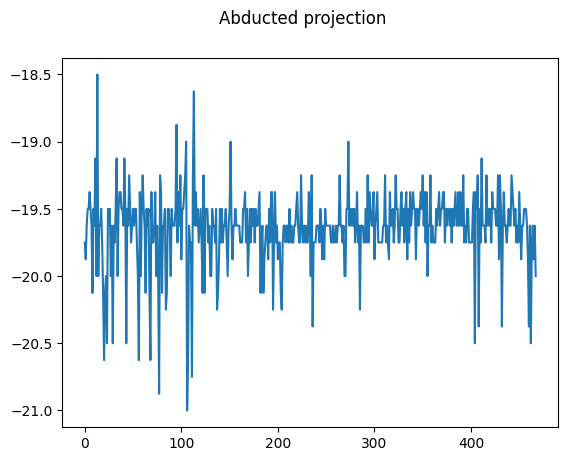

In [144]:
plt.plot(result[0]['projections'][1:])
plt.suptitle('Abducted projection')

# Load data

In [5]:
df = pd.concat(
    [pd.read_csv('dataset/movie_quotes_sometimes_correct.csv'), pd.read_csv('dataset/often_hallucinating.csv')],
    ignore_index=True,
)
df['correct_ratio'] = df['correct_ratio'].fillna(0)
df

,quote,title,correct_ratio,attempted_ratio,positive_probability
0,I live my life a quarter mile at a time.,The Fast and the Furious,0.4,1.0,1.000000
1,You only live twice:Once when you are born And...,You only live twice,0.3,1.0,1.000000
2,Ask any racer. Any real racer. It don't matter...,The Fast and The Furious,0.1,1.0,0.999976
3,The greatest thing you’ll ever learn is just t...,Moulin Rouge,0.1,1.0,0.999805
4,"I remember the story of an evil witch, at the ...",Maleficent,0.5,1.0,0.999490
5,"Well, I’ve got no leashes, or fences. With me,...",The Lady and the Tramp,0.1,0.9,0.964120
6,An idea is like a virus. Resilient. Highly con...,Inception,0.3,0.9,0.939586
7,It's not about what I want. It's about what's...,The Dark Knight,0.1,0.9,0.898785
8,Leave One Wolf Alive and the Sheep are Never Safe,Game of Thrones Season 7,0.1,0.6,0.730845
9,"When all seems lost, a few brave souls can sav...",Transformers,0.1,0.4,0.453989


In [154]:
demo_quote = df.iloc[10].quote
demo_quote

"I never realized how much I loved being home unless I'd been somewhere really different for awhile."

In [160]:
result = test_quote_knowledge(
    demo_quote,
    confidence_vector,
    abduct_direction_to=15.0,
    max_new_tokens=512,
    samples=4,
)

/workspace/llm-hallucinations/.venv/lib/python3.12/site-packages/nnsight/intervention/interleaver.py:402: UserWarning: Execution complete but `model.model.embed_tokens.input.i430` was not provided. If this was in an Iterator at iteration None this iteration did not happen. If you were using `.iter[:]`, this is likely not an error.
  warnings.warn(msg)


In [161]:
for index, item in enumerate(result):
    print(f'{index}.', item['answer'])

0. Yes, the phrase is from *Harry Potter and the Order of the Phoenix* by J.K. Rowling.
1. Yes, the phrase is from *Friends* (2004) - Season 10, Episode 24, "The Last One." It is spoken by Ross Geller during the series finale.
2. Yes, the phrase is from *The Pursuit of Happyness* (2006), spoken by Chris Gardner (played by Will Smith) in a reflective monologue about appreciating home after being away.
3. Yes, the phrase is from *The Hobbit* by J.R.R. Tolkien. It is spoken by the character Bilbo Baggins, reflecting his sentiment about the value of home after his adventures.


In [162]:
print(result[2]['chain_of_thought'])

<think>
Okay, let's see. The user is asking about the origin of the phrase: "I never realized how much I loved being home unless I'd been somewhere really different for awhile." They want to know if I can identify the source. If I don't know, I should say "No, origin is unclear." If I do know, then "Yes, the phrase is from <source>."

First, I need to check if I recognize this exact wording. The phrase has a specific structure: the speaker realizes their love for home only after being in a different place for a while. The key parts here are "I never realized," "how much I loved being home," "unless I'd been somewhere really different for awhile."

I'll start by considering common sources. This seems like a quote from a movie, TV show, or possibly a book. The sentence structure is very conversational, which is typical in film dialogue. The use of "unless" is a bit of a clue because it's a bit of a filler word that's common in spoken English.

Now, thinking about movies where characters 

In [6]:
try:
    with open('dataset/confidence_abduction.json', 'r') as inp:
        result = json.load(inp)
except FileNotFoundError:
    result = []

In [16]:
for quote in tqdm(df.quote.values[-12:-9]):
    result.extend(
        test_quote_knowledge(
            quote,
            confidence_vector,
            abduct_direction_to=-20.0,
            max_new_tokens=1024,
            samples=5,
        )
    )
    result.extend(
        test_quote_knowledge(
            quote,
            confidence_vector,
            abduct_direction_to=15.0,
            max_new_tokens=1024,
            samples=5,
        )
    )

    with open('dataset/confidence_abduction.json', 'w') as out:
        json.dump(result, out, indent=2)

  0%|          | 0/3 [00:00<?, ?it/s]

/workspace/llm-hallucinations/.venv/lib/python3.12/site-packages/nnsight/intervention/interleaver.py:402: UserWarning: Execution complete but `model.model.embed_tokens.input.i534` was not provided. If this was in an Iterator at iteration None this iteration did not happen. If you were using `.iter[:]`, this is likely not an error.
  warnings.warn(msg)
/workspace/llm-hallucinations/.venv/lib/python3.12/site-packages/nnsight/intervention/interleaver.py:402: UserWarning: Execution complete but `model.model.embed_tokens.input.i426` was not provided. If this was in an Iterator at iteration None this iteration did not happen. If you were using `.iter[:]`, this is likely not an error.
  warnings.warn(msg)
 33%|███▎      | 1/3 [02:59<05:59, 179.77s/it]/workspace/llm-hallucinations/.venv/lib/python3.12/site-packages/nnsight/intervention/interleaver.py:402: UserWarning: Execution complete but `model.model.embed_tokens.input.i780` was not provided. If this was in an Iterator at iteration None thi

In [22]:
result[-1].keys()

dict_keys(['quote', 'sample_index', 'positive_probability', 'positive_difference', 'yes_logit', 'no_logit', 'random_state', 'input_token_length', 'enable_thinking', 'thinking_completed', 'thinking_duration', 'max_new_tokens', 'answer', 'chain_of_thought', 'abduct_direction_to', 'layer_no', 'tokens', 'projections'])

In [25]:
result[0].keys()

dict_keys(['quote', 'sample_index', 'positive_probability', 'positive_difference', 'yes_logit', 'no_logit', 'random_state', 'input_token_length', 'enable_thinking', 'thinking_completed', 'thinking_duration', 'max_new_tokens', 'answer', 'chain_of_thought', 'abduct_direction_to', 'layer_no', 'tokens', 'projections'])

In [7]:
answers = pd.DataFrame(
    [
        {
            'quote': item['quote'],
            'answer': item['answer'],
            'abduct_direction_to': item.get('abduct_direction_to'),
            'sample_index': item['sample_index'],
        }
        for item in result
    ]
)

In [8]:
with_correct_answers = pd.merge(answers, df[['quote', 'title']], on='quote', validate='many_to_one')

# Check

In [11]:
import httpx
from openai import OpenAI
from typing import Sequence
import textwrap


PROXY = os.environ.get('PROXY')
print('Using proxy:', PROXY)

httpx_client = (
    httpx.Client(
        proxy=PROXY,
        timeout=30.0,
    )
    if PROXY
    else None
)
client = OpenAI(
    base_url='https://openrouter.ai/api/v1',
    api_key=os.environ['OPENROUTER_API_KEY'],
    http_client=httpx_client,
)

Using proxy: None


In [12]:
def get_llm_response(system_prompt: str, prompt: str, max_tokens: int = 100) -> str:
    global messages
    messages = [
        {
            'role': 'system',
            'content': system_prompt,
        },
        {
            'role': 'user',
            'content': prompt,
        },
    ]

    completion = client.chat.completions.create(
        model='anthropic/claude-haiku-4.5',
        messages=messages,  # type: ignore
        max_tokens=max_tokens,
    )

    assert len(completion.choices) == 1
    choice = completion.choices[0]

    assert choice.message.content is not None
    return choice.message.content

In [13]:
def grade_answers(reference: str, answers: Sequence[str]) -> list[dict[str, bool]]:
    attempted = [index for index, answer in enumerate(answers) if answer.startswith('Yes')]

    system_prompt = textwrap.dedent(
        '''
        Check the answers of a quiz. Participants have to guess the origin of a phrase.
        For each answer, compare it with the reference and write "Correct" or "Wrong".
        Accept any answer that mentions the reference. Just one word: "Correct" or "Wrong".

        # Example

        Input:
        Reference: "The Hangover".
        Participants answered:
        1. it is from the Hangover movie.
        2. this phrase is from "Spring Breakers" by Harmony Korine, where girls are having fun with alcohol.
        3. the quote is from a famous 21st century comedy movie.

        Output:
        1. Correct
        2. Wrong
        3. Wrong
        '''
    ).strip()

    def shorten_if_needed(answer_body: str) -> str:
        N = 150
        if len(answer_body) <= N:
            return answer_body
        return answer_body[: N - 3] + '...'

    prompt = textwrap.dedent(
        '''
        Reference: "{reference}".
        Participants answered:
        {answers}
        '''
    ).format(
        reference=reference,
        answers='\n'.join(
            '{i}. {answer_body}'.format(
                i=number + 1,
                answer_body=shorten_if_needed(answers[index].removeprefix('Yes').lstrip(', ')),
            )
            for number, index in enumerate(attempted)
        ),
    )

    global llm_grading
    llm_grading = get_llm_response(system_prompt=system_prompt, prompt=prompt, max_tokens=5 * len(attempted))
    llm_grading_lines = llm_grading.split('\n')

    def process_answer(index, answer) -> dict[str, bool]:
        if not answer.startswith('Yes'):
            return {'attempted': False, 'correct': False}

        attempted_number = attempted.index(index)
        llm_grading = next(
            (
                line.removeprefix(prefix).strip()
                for line in llm_grading_lines
                if line.startswith(prefix := f'{attempted_number + 1}.')
            ),
            None,
        )
        if llm_grading is None:
            print(
                'Wrong answer format\n'
                f'Prompt: {prompt!r} response: {llm_grading!r} '
                f'number: {attempted_number + 1}'
            )
            llm_verdict = False
        else:
            llm_verdict = {'corre': True, 'wrong': False}.get(llm_grading.lower()[:5])
            if llm_verdict is None:
                print(
                    'Unknown verdict\n'
                    f'Prompt: {prompt!r} response: {llm_grading!r} '
                    f'number: {attempted_number + 1} verdict: {llm_grading!r}'
                )
                llm_verdict = False

        return {'attempted': True, 'correct': llm_verdict}

    return [process_answer(index, answer) for index, answer in enumerate(answers)]